In [167]:
# Import
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import FastText # To use fastText for word embeddings
from sklearn.feature_extraction.text import TfidfVectorizer # to use tfidf for word embeddings
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
# Open data
# Opening JSON file
f = open('../data/raw/CMS_2010_to_June_2022_ENGLISH.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

df = pd.DataFrame.from_dict(data)

print(df.head())

         id                                               name  \
0  16489913                 UN imposes sanctions on DRC rebels   
1  16489912            Catholic Church abuse hotline goes cold   
2  16489903  "Fiscal cliff" tax hikes go into effect in the US   
3  16490025  Kim seeks reconciliation with South, economic ...   
4  16490029  Senate-approved fiscal deal faces House consid...   

                    shortTitle  \
0      UN sanctions DRC rebels   
1                 Disconnected   
2  US goes over "fiscal cliff"   
3    A rare New Year's address   
4   US House mulls fiscal deal   

                                                text  \
0  <p>\n\tThe UN Security Council has sanctioned ...   
1  <p>\n\tFor two and a half years, the counselin...   
2  <p>\n\tAs the clock struck midnight in Washing...   
3  <p>\n\tKim Jong Un, who came to office just ov...   
4  <p>\n\tLess than two hours after the US had of...   

                                              teaser  \
0  A 

In [4]:
df['firstKeyword'] = df['keywords'].apply(lambda x: x[0]['name'] if len(x) != 0 else None)
df['secondKeyword'] = df['keywords'].apply(lambda x: x[1]['name'] if len(x) > 1 else None)
df['thirdKeyword'] = df['keywords'].apply(lambda x: x[2]['name'] if len(x) > 2 else None)
df['fourthKeyword'] = df['keywords'].apply(lambda x: x[3]['name'] if len(x) > 3 else None)

df['cleanFocusCategory'] = df['thematicFocusCategory'].apply(lambda x: x['name'] if x is not None else x)

df = df[['firstKeyword', 'secondKeyword', 'thirdKeyword', 'fourthKeyword', 'thematicFocusCategory', 'cleanFocusCategory']]

In [5]:
# Playground Magda

df.dropna(subset=['thematicFocusCategory'], inplace=True) # Drop rows without a category
df.reset_index(inplace=True, drop=True) # reset index

df

,firstKeyword,secondKeyword,thirdKeyword,fourthKeyword,thematicFocusCategory,cleanFocusCategory
0,Africalink,Top Story,Africa on the Move,Making a Difference,{'name': 'History'},History
1,Commerzbank,job cuts,administration,retail banking,{'name': 'Business'},Business
2,Moody's,Turkey,ratings agency,junk status,{'name': 'Business'},Business
3,Syria,Aleppo,war crimes,water,{'name': 'Conflicts'},Conflicts
4,Conflict Zone,Talk,link,None,{'name': 'Politics'},Politics
...,...,...,...,...,...,...
79908,Turkey,Recep Tayipp Erdogan,Finland Sweden,NATO,{'name': 'Politics'},Politics
79909,pollution,gold mine,Turkey,Anagold,{'name': 'Nature and Environment'},Nature and Environment
79910,war,Ukraine,Russia,Russian attack,{'name': 'Conflicts'},Conflicts
79911,France,vegetarian,steak,sausage,{'name': 'Business'},Business


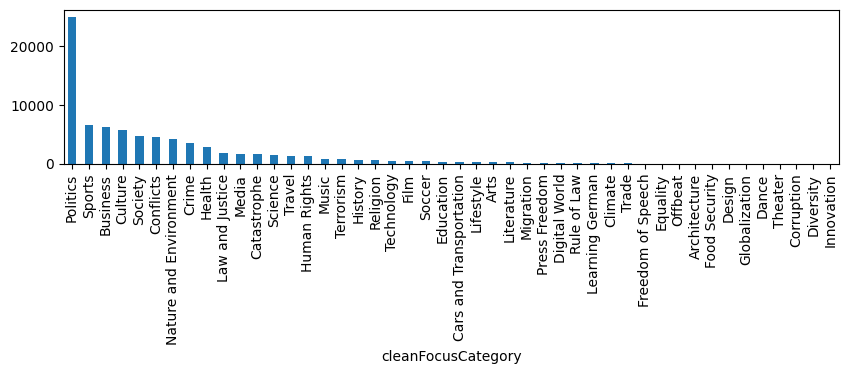

In [6]:
# Look only at first keyword
# Imbalanced classes (Category)
fig = plt.figure(figsize=(10,2))
df.groupby('cleanFocusCategory').firstKeyword.count().sort_values(ascending=False).plot.bar()
plt.show()

# NB: Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. 
# Minority classes can be treated as outliers, problem for cancer detection for instance. 

# Solution: Use stratify in test train split !

In [180]:
# TODO: translation: some keywords are in german: 'Commerzbank', 'DW Akademie'. Some keywords are strange: 'Africalink'

df.firstKeyword.describe()

count       79913
unique      14868
top       Germany
freq         2735
Name: firstKeyword, dtype: object

## Word embedding
= Convert each word into a vector. E.g., TFIDF; Word2vec, FastText, ...

In [178]:
# TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.firstKeyword).toarray()
features.shape # if single word: 1 feature, if 2 words: 3 features (e.g., 'dw', 'akademie', 'dw akademie')

(79913, 22306)

In [183]:
# FastText
tokens = [keyword.split() for keyword in df.firstKeyword] # tokenise: split into words
model_ft = FastText(tokens, vector_size = 100) # model_ft.wv['pollution']: get word vector for a specific word; model_ft.wv.similar_by_word('pollution', topn=5): Look for the 5 most similar words

word_vectors = [np.array(model_ft.wv[token]) for token in tokens]
word_vectors_av = np.array([np.average(word_vector, axis=0) for word_vector in word_vectors]) # if: ['dw','akademie'] = 2 vectors = here we average them

features = word_vectors_av
features.shape

(79913, 100)

## Run classification model

In [184]:
labels = df['cleanFocusCategory']

print(len(tokens))      # words 
print(len(features))    # words encoded in vectors = model input
print(len(labels))      # Focuscategory = model output

# Train test split with stratify to account for imbalanced category labels
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, 
                                                                                 random_state=0,stratify=labels)

79913
79913
79913


In [185]:
model = LinearSVC()
model.fit(X_train, y_train)

In [165]:
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

## Plot results

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred, labels = labels.unique().tolist())
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, xticklabels=True, yticklabels=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()